In [1]:
import sys
import json
import os
import random
import hashlib
import warnings
import urllib.request
import time

import warnings

warnings.filterwarnings(action='ignore')
random.seed(47)

### import gremlin_python packages

In [2]:
from gremlin_python import statics
from gremlin_python.structure.graph import Graph
from gremlin_python.process.graph_traversal import __
from gremlin_python.process.strategies import *
from gremlin_python.process.traversal import T, P, Operator, Scope, Column, Order
from gremlin_python.process.anonymous_traversal import traversal
from gremlin_python.driver.driver_remote_connection import DriverRemoteConnection

### Neptune endpoint 설정

In [3]:
NEPTUNE_ENDPOINT = 'octemberbizcard.cnrh6fettief.us-east-1.neptune.amazonaws.com'
NEPTUNE_PORT = 8182

In [4]:
def graph_traversal(neptune_endpoint=None, neptune_port=NEPTUNE_PORT, show_endpoint=True, connection=None):
  def _remote_connection(neptune_endpoint=None, neptune_port=None, show_endpoint=True):
    neptune_gremlin_endpoint = '{protocol}://{neptune_endpoint}:{neptune_port}/{suffix}'.format(protocol='ws',
      neptune_endpoint=neptune_endpoint, neptune_port=neptune_port, suffix='gremlin')

    if show_endpoint:
      print('gremlin: {}'.format(neptune_gremlin_endpoint))
    retry_count = 0
    while True:
      try:
        return DriverRemoteConnection(neptune_gremlin_endpoint, 'g')
      except HTTPError as ex:
        exc_info = sys.exc_info()
        if retry_count < 3:
          retry_count += 1
          print('Connection timeout. Retrying...')
        else:
          raise exc_info[0].with_traceback(exc_info[1], exc_info[2])

  if connection is None:
    connection = _remote_connection(neptune_endpoint, neptune_port, show_endpoint)
  return traversal().withRemote(connection)

In [5]:
def clear_graph(neptune_endpoint=None, neptune_port=NEPTUNE_PORT, batch_size=200, edge_batch_size=None, vertex_batch_size=None):
  if edge_batch_size is None:
    edge_batch_size = batch_size
  if vertex_batch_size is None:
    vertex_batch_size = batch_size
  g = graph_traversal(neptune_endpoint, neptune_port, False)
  has_edges = True
  edge_count = None
  while has_edges:
    if edge_count is None:
      print('clearing property graph data [edge_batch_size={}, edge_count=Unknown]...'.format(edge_batch_size))
    else:
      print('clearing property graph data [edge_batch_size={}, edge_count={}]...'.format(edge_batch_size, edge_count))
    g.E().limit(edge_batch_size).drop().toList()
    edge_count = g.E().count().next()
    has_edges = (edge_count > 0)
  has_vertices = True
  vertex_count = None
  while has_vertices:
    if vertex_count is None:
      print('clearing property graph data [vertex_batch_size={}, vertex_count=Unknown]...'.format(vertex_batch_size))
    else:
      print('clearing property graph data [vertex_batch_size={}, vertex_count={}]...'.format(vertex_batch_size, vertex_count))
    g.V().limit(vertex_batch_size).drop().toList()
    vertex_count = g.V().count().next()
    has_vertices = (vertex_count > 0)

In [6]:
def get_person(g, person_id):
    person = g.V(person_id).toList()
    return None if not person else person[-1]

In [7]:
def upsert_person(g, person):
    person_vertex = get_person(g, person['id'])
    elem = g.addV('person').property(T.id, person['id']).next() if not person_vertex else g.V(person_vertex).next()
    for k in ('id', 'name', 'email', 'phone_number', 'company', 'job_title'):
        g.V(elem).property(k, person[k]).next()
    g.V(elem).property('_name', person['name'].lower()).next()

    _from_person_id = hashlib.md5(person['owner'].encode('utf-8')).hexdigest()[:8]
    _to_person_id = person['id']
    if _from_person_id != _to_person_id:
        from_person_vertex = get_person(g, _from_person_id)
        to_person_vertex = get_person(g, _to_person_id)
        weight = 1.0
        if g.V(from_person_vertex).outE('knows').filter(__.inV().is_(to_person_vertex)).toList():
            print('Updating relationship')
            g.V(from_person_vertex).outE('knows').filter(__.inV().is_(to_person_vertex)).property('weight', weight).next()
        else:
            print('Creating relationship')
            g.V(from_person_vertex).addE('knows').to(to_person_vertex).property('weight', weight).next()

In [8]:
def _print_all_vertices(g):
  import pprint
  all_persons = [{**node.__dict__, **properties} for node in g.V()
              for properties in g.V(node).valueMap()]
  pprint.pprint(all_persons)

### Neptune 데이터베이스 초기화

In [9]:
neptune_endpoint, neptune_port = (NEPTUNE_ENDPOINT, NEPTUNE_PORT)

In [10]:
clear_graph(neptune_endpoint)

clearing property graph data [edge_batch_size=200, edge_count=Unknown]...
clearing property graph data [vertex_batch_size=200, vertex_count=Unknown]...


In [11]:
g = graph_traversal(neptune_endpoint, neptune_port)

gremlin: ws://octemberbizcard.cnrh6fettief.us-east-1.neptune.amazonaws.com:8182/gremlin


In [12]:
_print_all_vertices(g)

[]


### load 테스트용 데이터

In [13]:
person_list = [
{'id': 'c3ec9392', 'name': 'Sungmin Kim', 'email': 'sungmk@amazon.com', 'phone_number': '(+82 10) 1025 7049', 'company': 'aws', 'job_title': 'Solutions Architect', 'owner': 'sungmk'},
{'id': '3eb38c72', 'name': 'Injae Park', 'email': 'ijpark@amazon.com', 'phone_number': '(+82 10) 7433 9352', 'company': 'aws', 'job_title': 'Solutions Architect', 'owner': 'sungmk'},
{'id': '37bf4c56', 'name': 'JinSeo Jang', 'email': 'jjinseo@amazon.com', 'phone_number': '(+82 10) 4218 8396', 'company': 'aws', 'job_title': 'Solutions Architect', 'owner': 'sungmk'},
{'id': '37307fd8', 'name': 'Hyounsoo Kim', 'email': 'hyouk@amazon.com', 'phone_number': '(+82 10) 6430 0671', 'company': 'aws', 'job_title': 'Solutions Architect', 'owner': 'sungmk'},

{'id': '37307fd8', 'name': 'Hyounsoo Kim', 'email': 'hyouk@amazon.com', 'phone_number': '(+82 10) 6430 0671', 'company': 'aws', 'job_title': 'Solutions Architect', 'owner': 'hyouk'},
{'id': 'c3ec9392', 'name': 'Sungmin Kim', 'email': 'sungmk@amazon.com', 'phone_number': '(+82 10) 1025 7049', 'company': 'aws', 'job_title': 'Solutions Architect', 'owner': 'hyouk'},
{'id': 'fbac3273', 'name': 'Kevin Kim', 'email': 'kevkim@amazon.com', 'phone_number': '(+82 10) 8957 0150', 'company': 'aws', 'job_title': 'Solutions Architect', 'owner': 'hyouk'},
{'id': '15585b4e', 'name': 'Daniel Yoo', 'email': 'danieyoo@amazon.com', 'phone_number': '(+82 10) 4323 7890', 'company': 'aws', 'job_title': 'Solutions Architect', 'owner': 'hyouk'},

{'id': 'fbac3273', 'name': 'Kevin Kim', 'email': 'kevkim@amazon.com', 'phone_number': '(+82 10) 8957 0150', 'company': 'aws', 'job_title': 'Solutions Architect', 'owner': 'kevkim'},
{'id': '3eb38c72', 'name': 'Injae Park', 'email': 'ijpark@amazon.com', 'phone_number': '(+82 10) 7433 9352', 'company': 'aws', 'job_title': 'Solutions Architect', 'owner': 'kevkim'},
{'id': '37bf4c56', 'name': 'JinSeo Jang', 'email': 'jjinseo@amazon.com', 'phone_number': '(+82 10) 4218 8396', 'company': 'aws', 'job_title': 'Solutions Architect', 'owner': 'kevkim'},
]

In [14]:
for person in person_list:
    upsert_person(g, person)

Creating relationship
Creating relationship
Creating relationship
Creating relationship
Creating relationship
Creating relationship
Creating relationship
Creating relationship


In [15]:
_print_all_vertices(g)

[{'_name': ['sungmin kim'],
  'company': ['aws'],
  'email': ['sungmk@amazon.com'],
  'id': ['c3ec9392'],
  'job_title': ['Solutions Architect'],
  'label': 'person',
  'name': ['Sungmin Kim'],
  'phone_number': ['(+82 10) 1025 7049']},
 {'_name': ['hyounsoo kim'],
  'company': ['aws'],
  'email': ['hyouk@amazon.com'],
  'id': ['37307fd8'],
  'job_title': ['Solutions Architect'],
  'label': 'person',
  'name': ['Hyounsoo Kim'],
  'phone_number': ['(+82 10) 6430 0671']},
 {'_name': ['jinseo jang'],
  'company': ['aws'],
  'email': ['jjinseo@amazon.com'],
  'id': ['37bf4c56'],
  'job_title': ['Solutions Architect'],
  'label': 'person',
  'name': ['JinSeo Jang'],
  'phone_number': ['(+82 10) 4218 8396']},
 {'_name': ['kevin kim'],
  'company': ['aws'],
  'email': ['kevkim@amazon.com'],
  'id': ['fbac3273'],
  'job_title': ['Solutions Architect'],
  'label': 'person',
  'name': ['Kevin Kim'],
  'phone_number': ['(+82 10) 8957 0150']},
 {'_name': ['injae park'],
  'company': ['aws'],
  'em

### 인맥 관계도 그리기

In [16]:
import matplotlib.pyplot as plt
import networkx as nx

plt.rcdefaults()

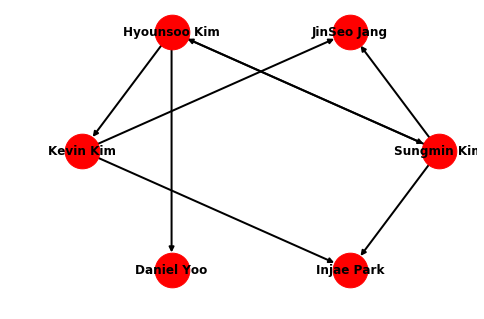

In [17]:
dg = nx.DiGraph()

path_list = g.V().out().path().by('name').toList()
for e in path_list:
    dg.add_edge(e[0], e[1])
nx.draw(dg, pos=nx.circular_layout(dg), with_labels=True, node_size=1200, width=2, font_weight='bold')

### 인맥 추천 (People You May Know, PYMK)

In [18]:
import pprint

user = 'Sungmin Kim'.lower()
recommendations = (g.V().hasLabel('person').has('_name', user).as_('person')
 .both('knows').aggregate('friends')
 .both('knows').where(P.neq('person')).where(P.without('friends'))
 .groupCount().by('id')
 .order(Scope.local)
 .by(Column.values, Order.decr)
 .next())

res = []
for key, score in recommendations.items():
    value = {k: v for k, v in g.V(key).valueMap().next().items() if not (k == 'id' or k.startswith('_'))}
    value['score'] = float(score)
    res.append(value)

for e in res:
    pprint.pprint(e)

{'company': ['aws'],
 'email': ['kevkim@amazon.com'],
 'job_title': ['Solutions Architect'],
 'name': ['Kevin Kim'],
 'phone_number': ['(+82 10) 8957 0150'],
 'score': 4.0}
{'company': ['aws'],
 'email': ['danieyoo@amazon.com'],
 'job_title': ['Solutions Architect'],
 'name': ['Daniel Yoo'],
 'phone_number': ['(+82 10) 4323 7890'],
 'score': 2.0}


### Reference

- https://github.com/nedlowe/gremlin-python-example/blob/master/app.py
- https://kelvinlawrence.net/book/Gremlin-Graph-Guide.html
- http://tinkerpop.apache.org/docs/current/reference/